* This notebook was made to investigate the effects of the Coriolis force on mixing.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import matplotlib.pyplot as plt
import StraTimeSeries as sts
import R_mixStuff as RS
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
%matplotlib inline

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 
e3t = mesh.variables['e3t'][0,:,380:510,240:397]

In [3]:
## load grid_T model results
octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')

octnof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc')
maynof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nof/may2015nof_T.nc')
jannof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nof/jan2016nof_T.nc')

In [4]:
## load grid_U model results
octall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
mayall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_U.nc')
janall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_U.nc')

octnof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_U.nc')
maynof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nof/may2015nof_U.nc')
jannof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nof/jan2016nof_U.nc')

In [5]:
## load grid_V model results
octall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')
mayall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_V.nc')
janall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_V.nc')

octnof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_V.nc')
maynof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nof/may2015nof_V.nc')
jannof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nof/jan2016nof_V.nc')

In [6]:
def get_Rmix(gridT1,gridT2,gridT3,gridT4,gridT5,tst,ted,dep_ind):
    """This function was made to get the time averaged Rmix"""
    rmix = {};
    for grid_T,st,in zip([gridT1,gridT2,gridT3,gridT4,gridT5],['onlyriver','river+tides',\
                        'river+winds','nof','all']):
        S = grid_T.variables['vosaline']
        lon = grid_T.variables['nav_lon']
        dep = grid_T.variables['deptht']

        S_ave = np.nanmean(S[tst:ted+1],axis = 0)
        rmix[st] = RS.R_mixAve(S_ave,np_mask,dep_ind)
    return rmix

In [7]:
def rmix_each(nof_T,all_T,tst,ted,dep_ind):
    """This function was made to plot the averaged Rmix spatial pattern
    of each run case"""
    rmix = get_Rmix(all_T,all_T,all_T,nof_T,all_T,tst,ted,dep_ind)
    lon = all_T.variables['nav_lon']
    lat = all_T.variables['nav_lat']
    fig,axs = plt.subplots(1,3,figsize=(20,6))
    levels1 = [0.1,0.3,0.5,0.7,0.9]
    levels2 = [-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2]
    for ti, ax in zip(['all','nof'],axs[:-1]):
        CS = ax.contourf(lon[:],lat[:],rmix[ti],levels=levels1,cmap = 'jet',extend='both')
        CS2 = ax.contour(CS, colors = 'k',hold='on',linewidths=(2,))
        cbar = fig.colorbar(CS,ax = ax, orientation = 'horizontal')
        cbar.add_lines(CS2)
        cbar.set_label('Rmix')
        ax.set_title(ti)
    ax = axs[-1]
    CS = ax.contourf(lon[:],lat[:],rmix['nof']-rmix['all'],levels=levels2,cmap = 'jet',extend='both')
    CS2 = ax.contour(CS, colors = 'k',hold='on',linewidths=(2,))
    cbar = fig.colorbar(CS,ax = ax, orientation = 'horizontal')
    cbar.add_lines(CS2)
    cbar.set_label('Rmix difference')
    ax.set_title('nof - all')
    for ax in axs:
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-124.,-122.8])
        ax.set_ylim([48.9,49.5])

In [8]:
def quiver_salinity(grid_T1,grid_T2,grid_U1,grid_U2,grid_V1,grid_V2,t,colormap,st,cmin = -6,cmax = 6):
    """Quiver velocity on top of surface salinity"""
    fig,axs = plt.subplots(1,3,figsize=(20,6))
    S = {};U = {};V= {}
    for gridT, gridU,gridV,run, ax in zip([grid_T1,grid_T2],[grid_U1,grid_U2],[grid_V1,grid_V2],['all','nof'],[axs[0],axs[1]]):
        S[run] =gridT.variables['vosaline'][t,0]
        S[run] = np.ma.masked_values(S[run],0)
        lon = gridT.variables['nav_lon']
        lat = gridT.variables['nav_lat']
        u = gridU.variables['vozocrtx'][t,0]
        v = gridV.variables['vomecrty'][t,0]
        U[run],V[run] = viz_tools.unstagger(u,v)
        #rotate
        theta = np.pi*29/180
        U[run] = U[run]*np.cos(theta) - V[run]*np.sin(theta)
        V[run] = U[run]*np.sin(theta) +V[run]*np.cos(theta)
        cm = plt.cm.get_cmap(colormap,12)
        mesh=ax.pcolormesh(lon,lat,S[run],vmin =0,vmax = 33,cmap=cm) 
        quiver = ax.quiver(lon[1::st,1::st], lat[1::st,1::st],U[run][::st, ::st], V[run][::st,::st],\
                           pivot='mid',scale=15,width=0.005, color='black' )
        ax.quiverkey(quiver,-123.1,49.25, 1, '1 m/s',coordinates='data', color='black', labelcolor='black')
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-124.,-122.8])
        ax.set_ylim([48.9,49.5])
        ## add minimum salinity plot if available
    sal_diff = S['nof'] - S['all']
    U_diff = U['nof'] - U['all']
    V_diff = V['nof'] - V['all']
    ax = axs[2]
    mesh=ax.pcolormesh(lon,lat,sal_diff,cmap='RdBu_r',vmin=cmin, vmax=cmax)
    quiver = ax.quiver(lon[1::st,1::st], lat[1::st,1::st],U_diff[ ::st, ::st], V_diff[::st,::st],\
                           pivot='mid',scale=15,width=0.005, color='black' )
    ax.quiverkey(quiver,-123.1,49.25, 1, '1 m/s',coordinates='data', color='black', labelcolor='black')
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.set_xlim([-124.,-122.8])
    ax.set_ylim([48.9,49.5])

In [17]:
def check_SUV_profile(grid_T1,grid_T2,grid_U1,grid_U2,grid_V1,grid_V2,t,j,i):
    fig,axs = plt.subplots(2,2,figsize = (12,10))
    S = {};U = {};V = {}
    for gridT, gridU,gridV,run in zip([grid_T1,grid_T2],[grid_U1,grid_U2],[grid_V1,grid_V2],['all','nof']):
        S[run] =gridT.variables['vosaline'][t,:,j,i]
        S[run] = np.ma.masked_values(S[run],0)
        dep = gridT.variables['deptht']
        lon = gridT.variables['nav_lon']
        lat = gridT.variables['nav_lat']
        u = gridU.variables['vozocrtx'][t,:,j:j+2,i:i+2]
        v = gridV.variables['vomecrty'][t,:,j:j+2,i:i+2]
        U[run],V[run] = viz_tools.unstagger(u,v)   
    ax = axs[0,0]
    ax.plot(S['all'],dep[:],'b',label ='all')
    ax.plot(S['nof'],dep[:],'g',label ='nof')
    ax.legend()
    ax.set_ylim([dep[24],dep[0]])
    ax= axs[0,1]
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.set_xlim([-124.,-122.8])
    ax.set_ylim([48.9,49.7])
    ax.plot(X[j+380,i+240],Y[j+380,i+240],'*',markersize = 12)
    ax= axs[1,0]
    ax.plot(U['all'][:,0,0],dep[:],'b',label ='all')
    ax.plot(U['nof'][:,0,0],dep[:],'g',label ='nof')
    ax.legend()
    ax.set_ylim([dep[24],dep[0]])
    ax = axs[1,1]
    ax.plot(V['all'][:,0,0],dep[:],'b',label ='all')
    ax.plot(V['nof'][:,0,0],dep[:],'g',label ='nof')
    ax.legend()
    ax.set_ylim([dep[24],dep[0]])

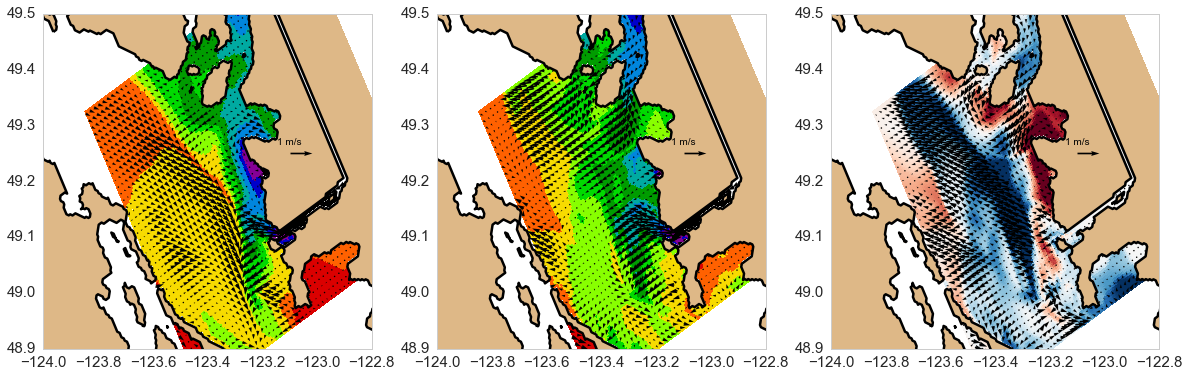

In [10]:
quiver_salinity(octall_T,octnof_T,octall_U,octnof_U,octall_V,octnof_V,50,'spectral',3)

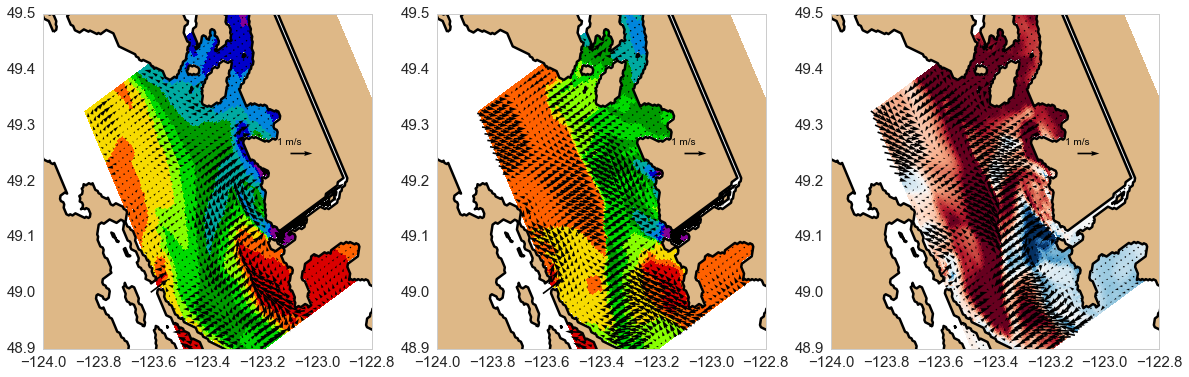

In [11]:
quiver_salinity(octall_T,octnof_T,octall_U,octnof_U,octall_V,octnof_V,190,'spectral',3)

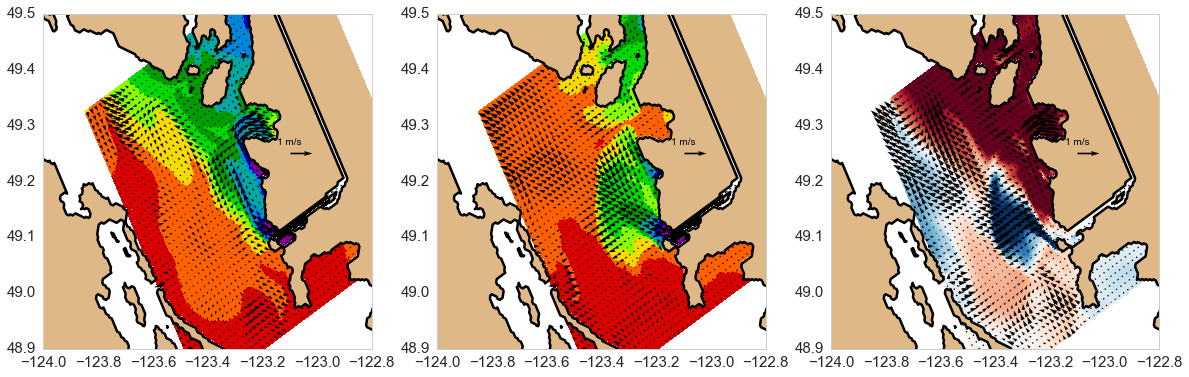

In [12]:
quiver_salinity(octall_T,octnof_T,octall_U,octnof_U,octall_V,octnof_V,725,'spectral',3)

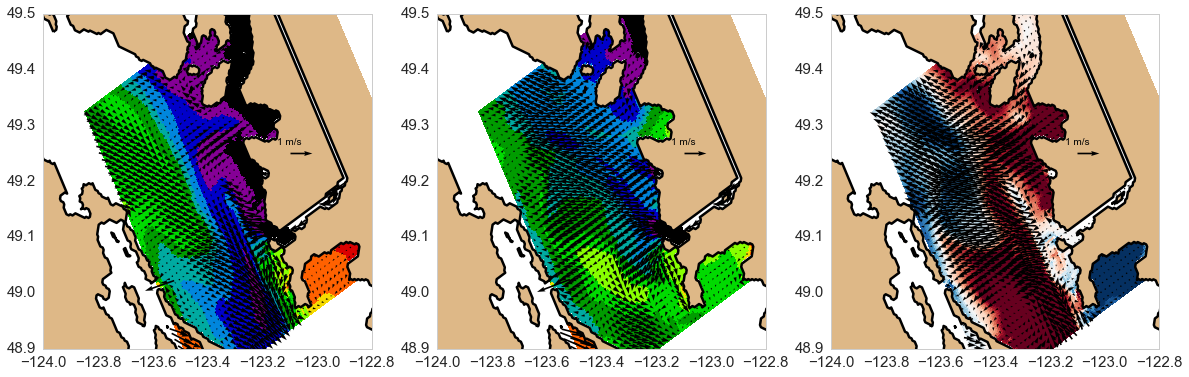

In [13]:
quiver_salinity(mayall_T,maynof_T,mayall_U,maynof_U,mayall_V,maynof_V,733,'spectral',3)

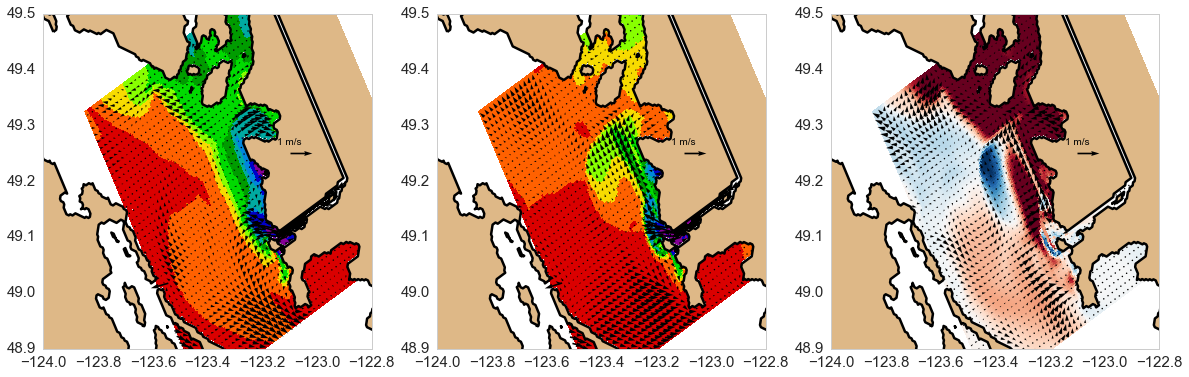

In [14]:
quiver_salinity(janall_T,jannof_T,janall_U,jannof_U,janall_V,jannof_V,704,'spectral',3)
## weird! why without f, northward flow is even stronger???

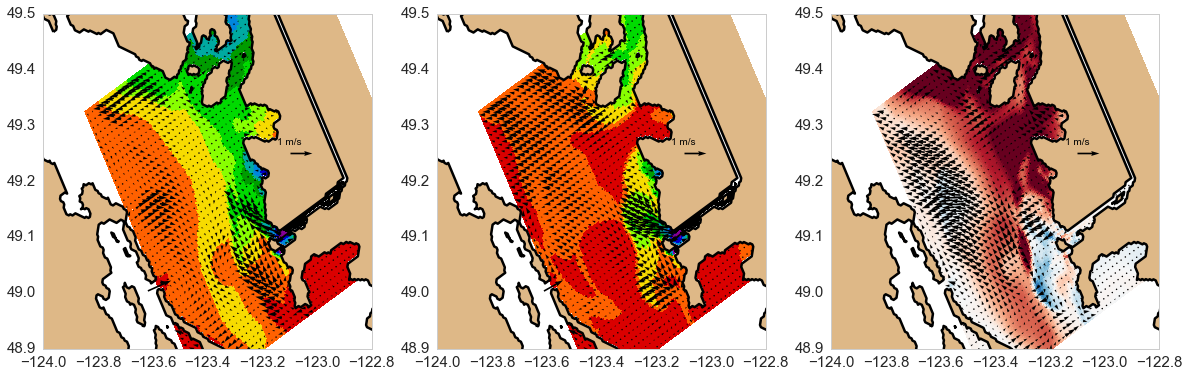

In [15]:
quiver_salinity(janall_T,jannof_T,janall_U,jannof_U,janall_V,jannof_V,622,'spectral',3)

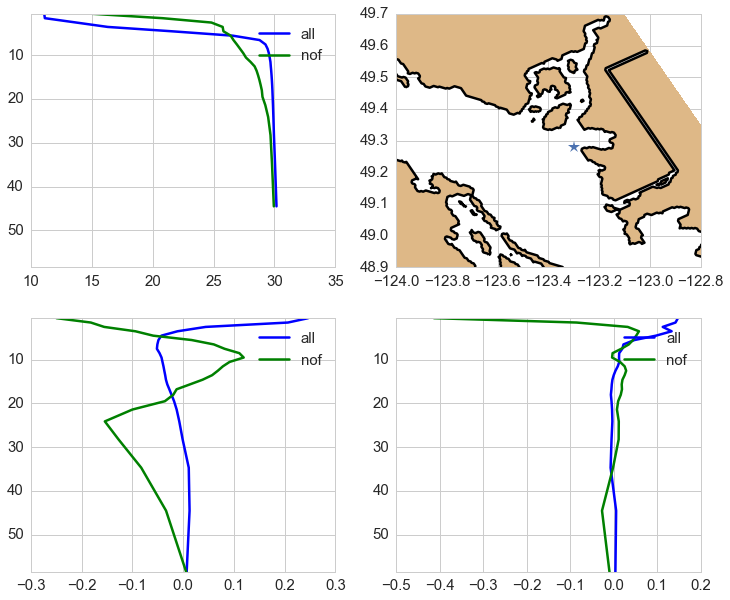

In [18]:
check_SUV_profile(octall_T,octnof_T,octall_U,octnof_U,octall_V,octnof_V,50,81,75)

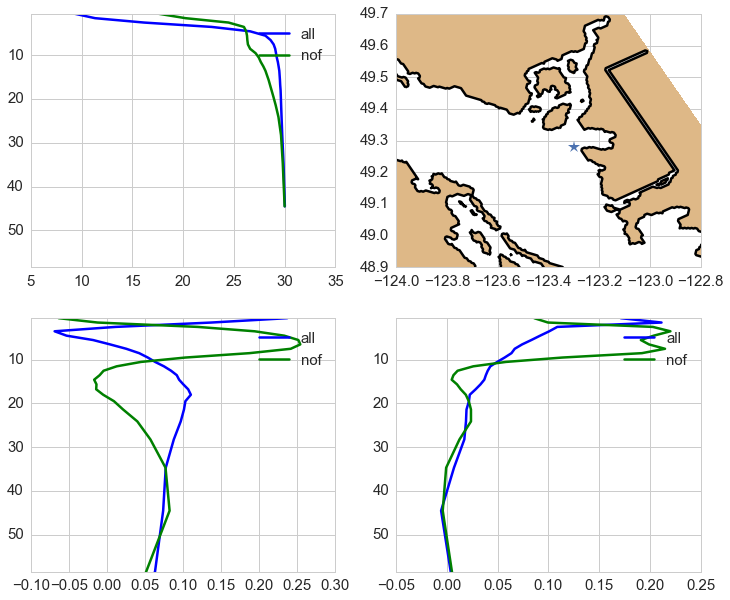

In [19]:
check_SUV_profile(octall_T,octnof_T,octall_U,octnof_U,octall_V,octnof_V,190,81,75)

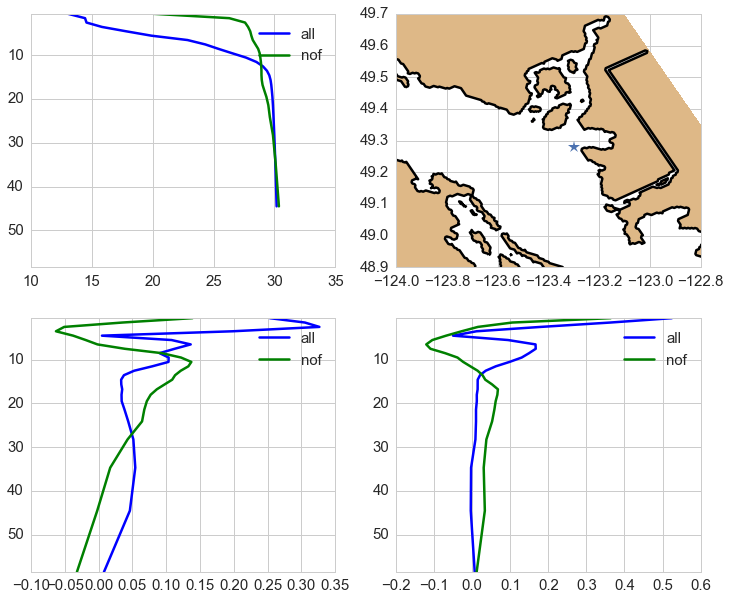

In [20]:
check_SUV_profile(octall_T,octnof_T,octall_U,octnof_U,octall_V,octnof_V,725,81,75)

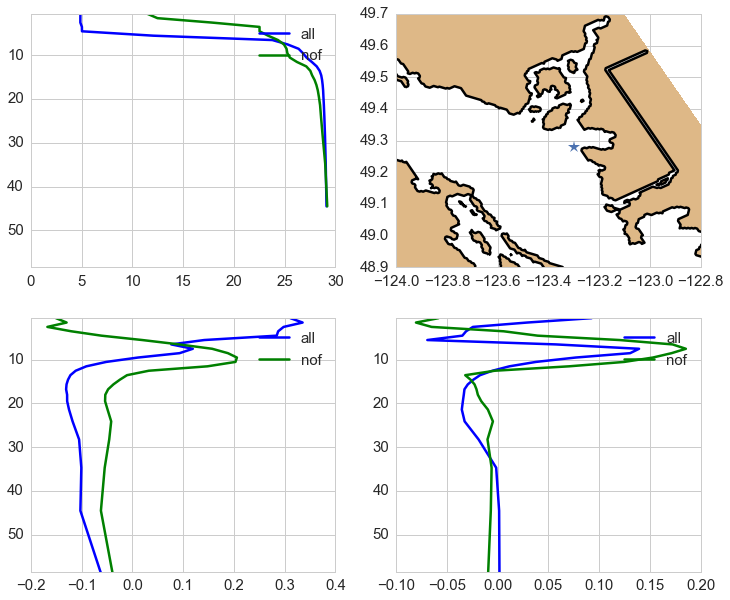

In [21]:
check_SUV_profile(mayall_T,maynof_T,mayall_U,maynof_U,mayall_V,maynof_V,733,81,75)

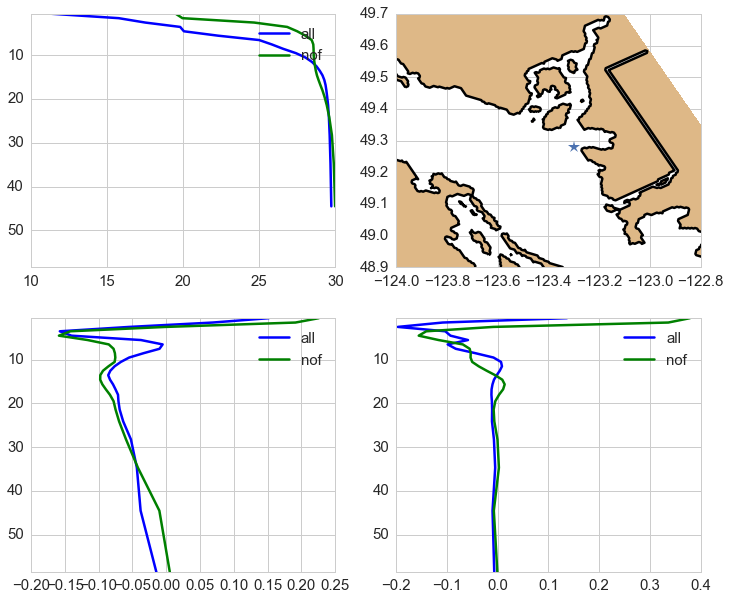

In [22]:
check_SUV_profile(janall_T,jannof_T,janall_U,jannof_U,janall_V,jannof_V,704,81,75)

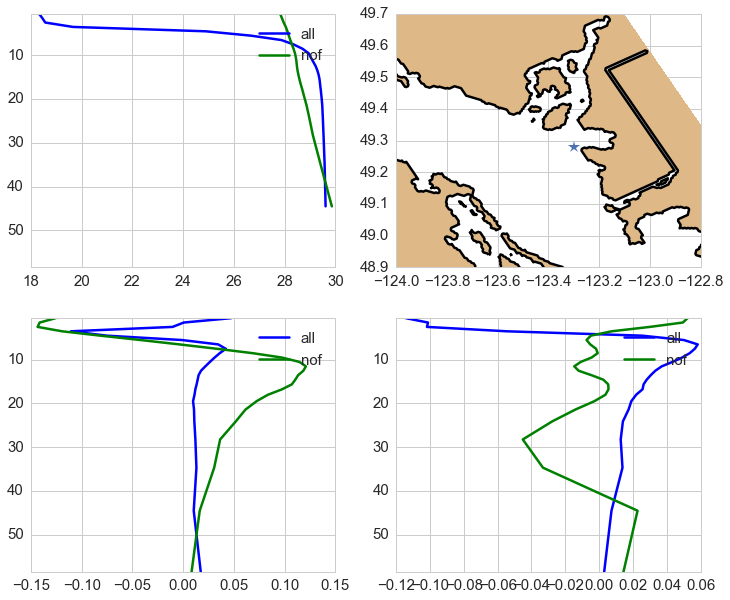

In [23]:
check_SUV_profile(janall_T,jannof_T,janall_U,jannof_U,janall_V,jannof_V,622,81,75)

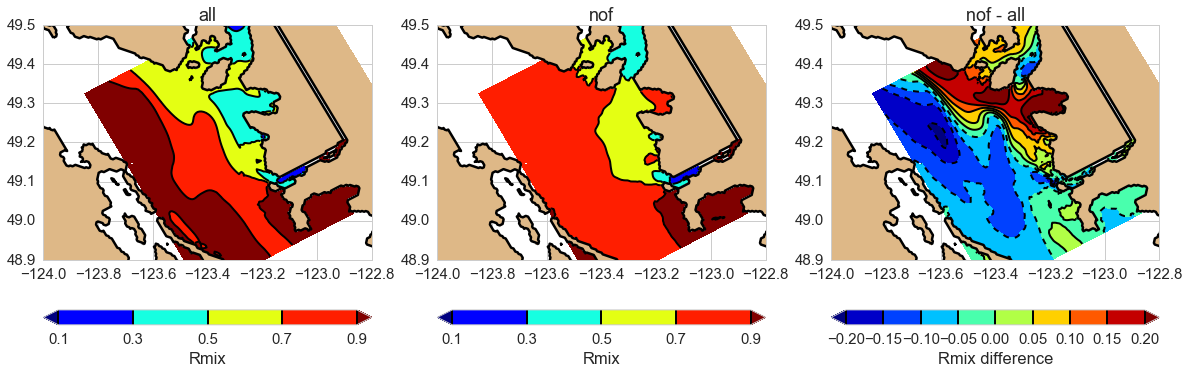

In [8]:
## weak wind october
rmix_each(octnof_T,octall_T,48,143,10)

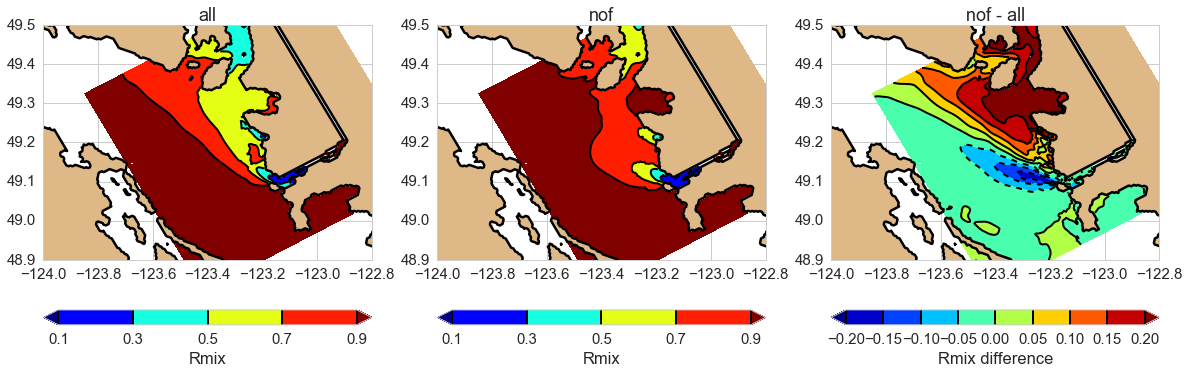

In [78]:
rmix_each(octnof_T,octall_T,408,480,10)

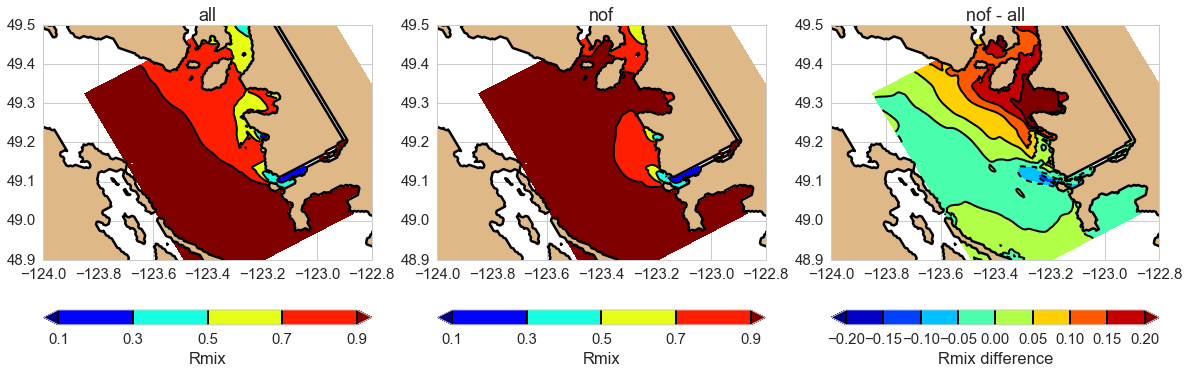

In [79]:
rmix_each(octnof_T,octall_T,480,551,10)

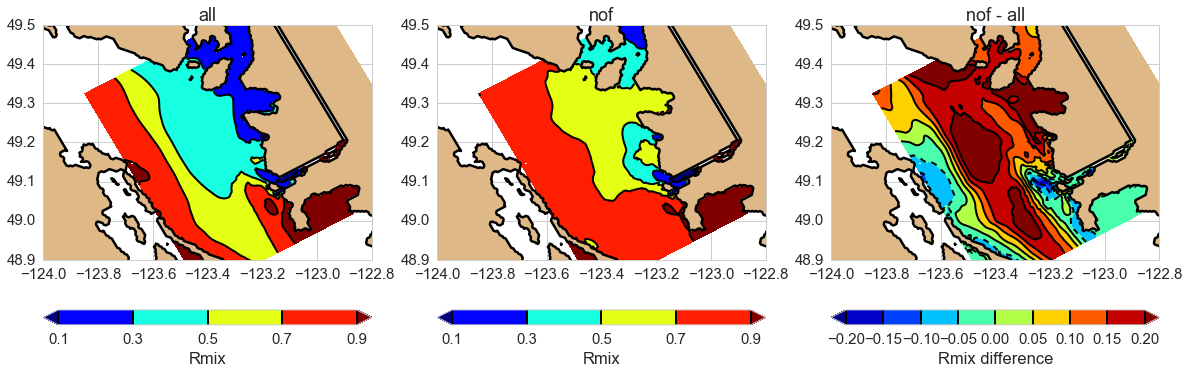

In [9]:
## weak wind may
rmix_each(maynof_T,mayall_T,192,263,10)

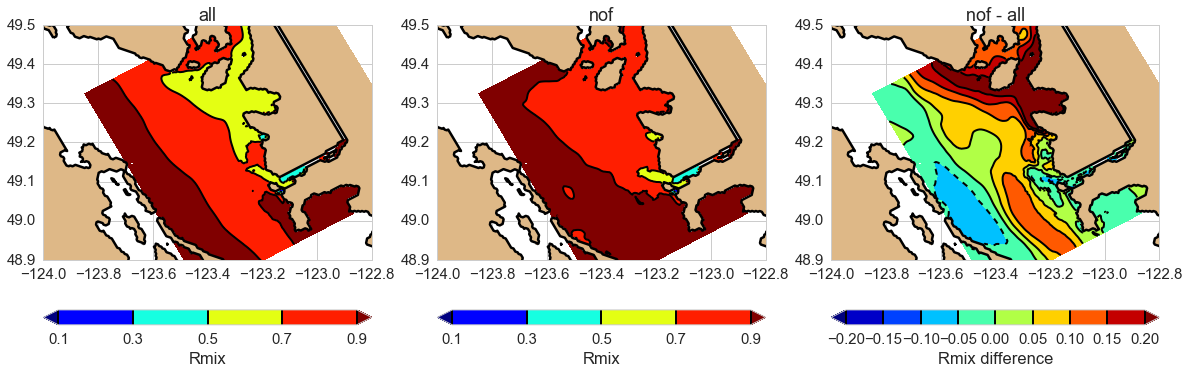

In [10]:
## weak wind jan
rmix_each(jannof_T,janall_T,168,239,10)

* Next, look at instantaneous time at ebb, slack and flood, respectively.

* October

In [19]:
ssh = {}; u = {}; v = {};S={}
for gridT, gridU, gridV, st in zip([octall_T,mayall_T,janall_T],[octall_U,mayall_U,janall_U],\
                                   [octall_V,mayall_V,janall_V],['oct','may','jan']):
    ssh[st] = gridT.variables['sossheig']
    u[st] = gridU.variables['vozocrtx']
    v[st] = gridV.variables['vomecrty']
    S[st] = gridT.variables['vosaline']
    dep = gridT.variables['deptht']

In [20]:
def select_tide_current(st,t1,t2,t3):
    """Plot ssh and u velocity at PA """
    UU,VV = viz_tools.unstagger(u[st][t1:t2,0,86:88,89:91],v[st][t1:t2,0,86:88,89:91])
    fig, axs = plt.subplots(2,1,figsize = (5,8))
    axs[0].plot(ssh[st][t1:t2,86,89])
    axs[0].plot(t3,ssh[st][t1+t3,86,89],'*')
    axs[1].plot(UU[0:t2-t1,0,0])    
    axs[1].plot(VV[0:t2-t1,0,0]) 
    axs[1].plot(t3,VV[t3,0,0],'*')

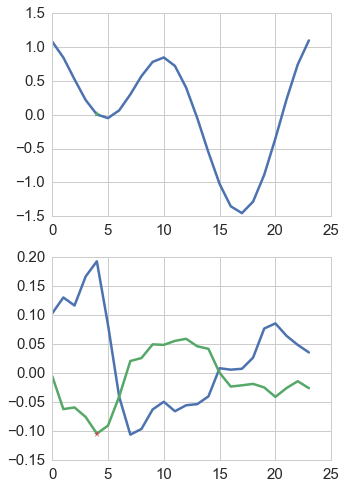

In [59]:
select_tide_current('oct',45,69,4)

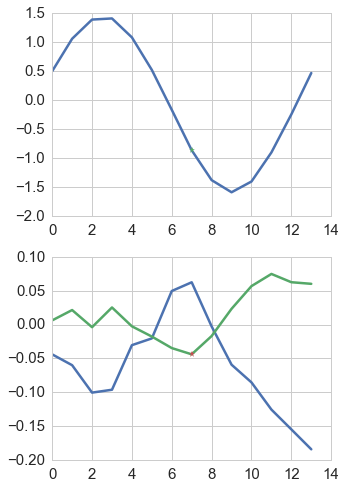

In [58]:
select_tide_current('oct',190,204,7)

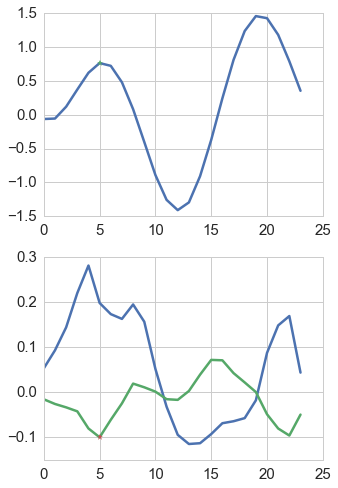

In [26]:
select_tide_current('oct',720,744,5)

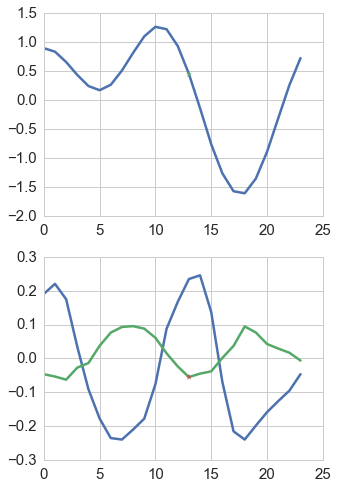

In [30]:
select_tide_current('may',720,744,13)

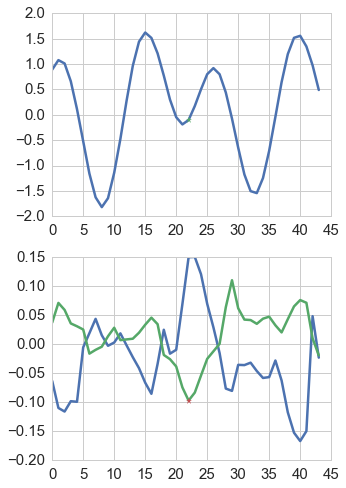

In [89]:
select_tide_current('jan',600,644,22)

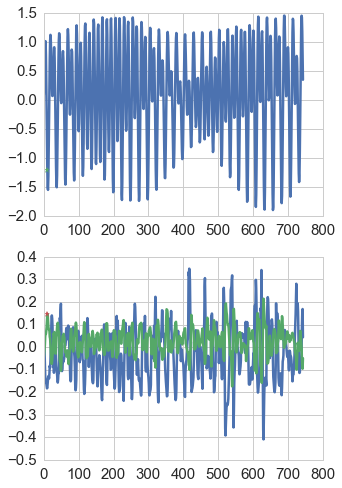

In [64]:
select_tide_current('oct',0,744,10)

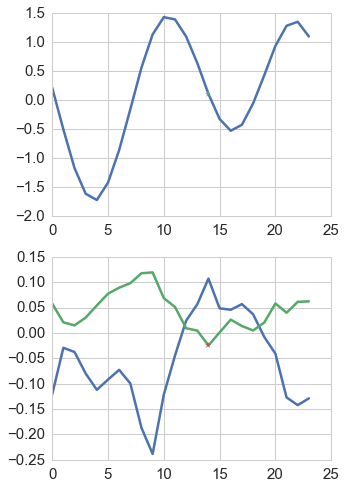

In [71]:
## spring tides
select_tide_current('oct',220,244,14)

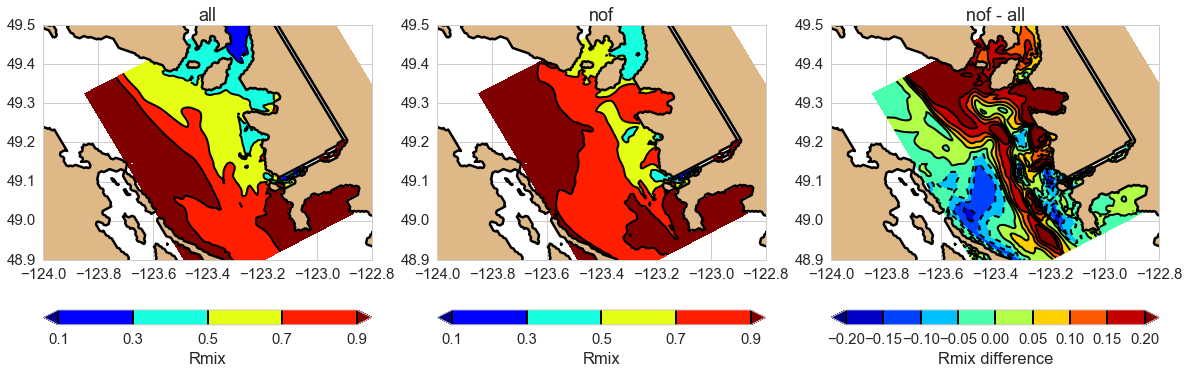

In [73]:
## spring tides
rmix_each(octnof_T,octall_T,220+14,220+14,10)

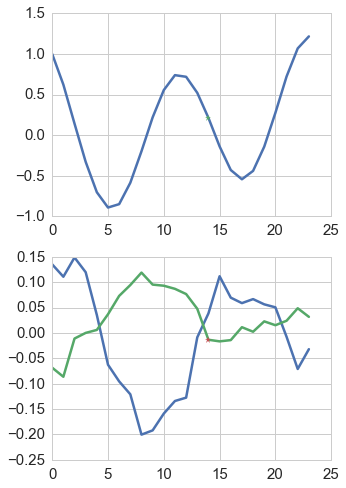

In [74]:
## neap tides
select_tide_current('oct',480,504,14)

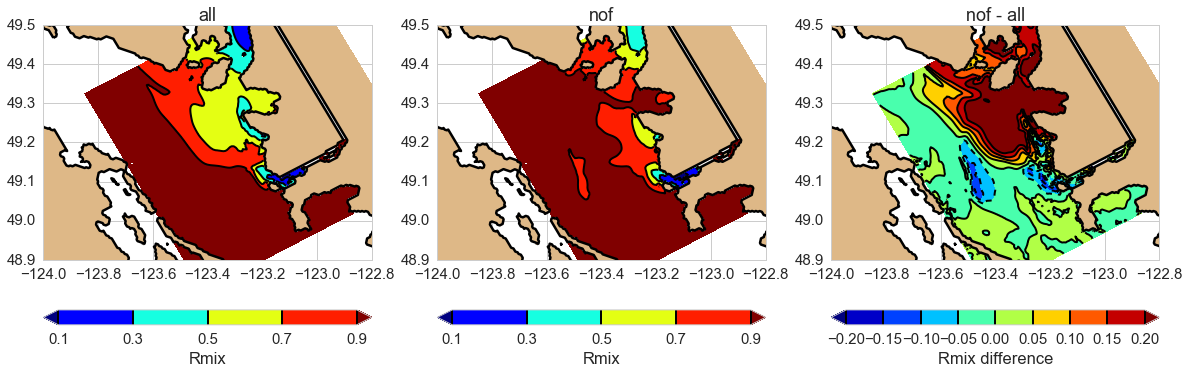

In [77]:
## neap tides
rmix_each(octnof_T,octall_T,480+14,480+14,10)

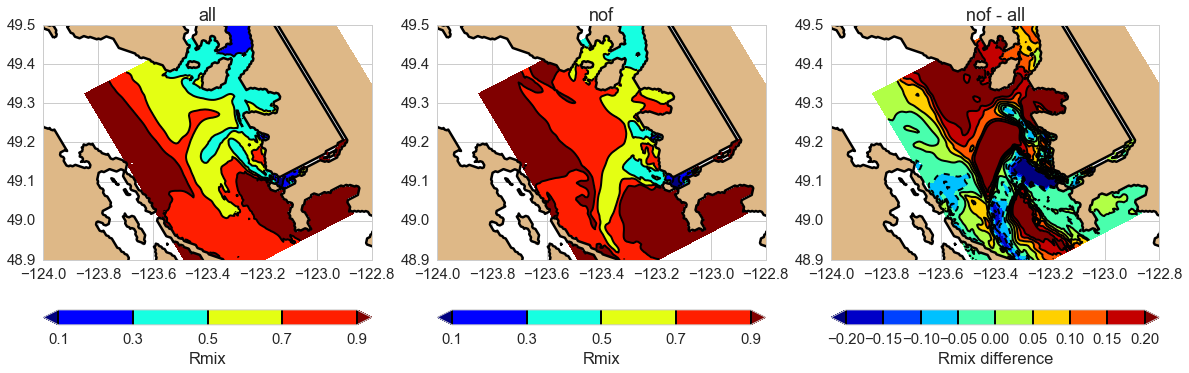

In [69]:
rmix_each(octnof_T,octall_T,220+8,220+8,10)

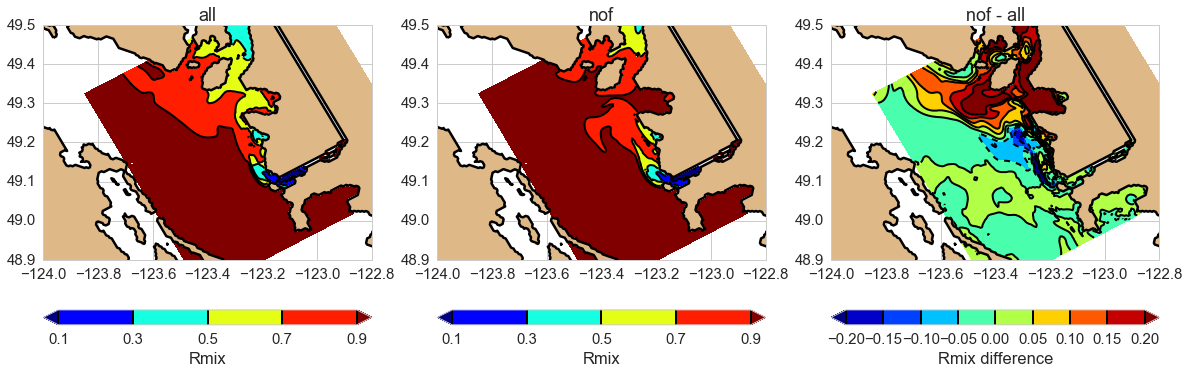

In [63]:
rmix_each(octnof_T,octall_T,408+10,408+10,10)

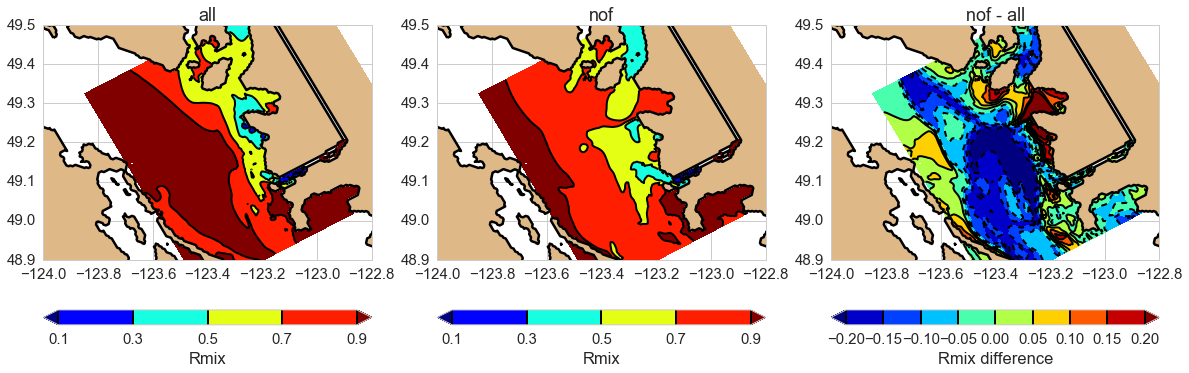

In [60]:
rmix_each(octnof_T,octall_T,45+4,45+4,10)

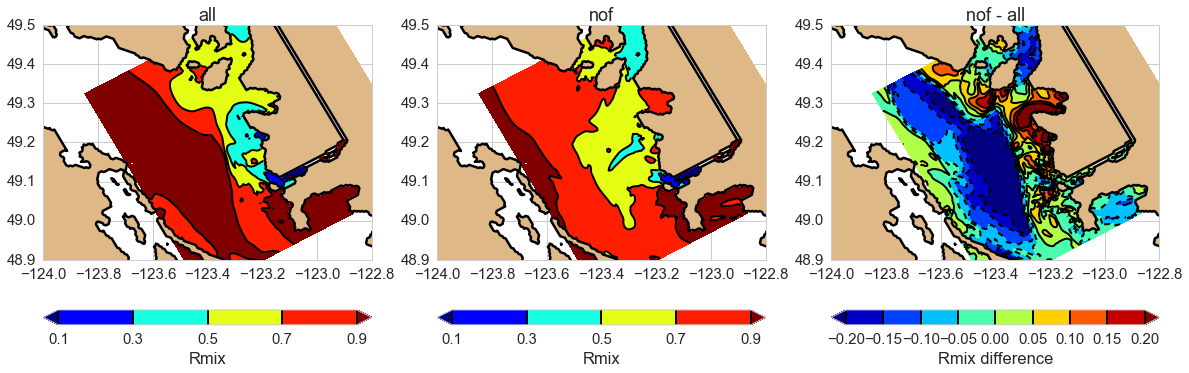

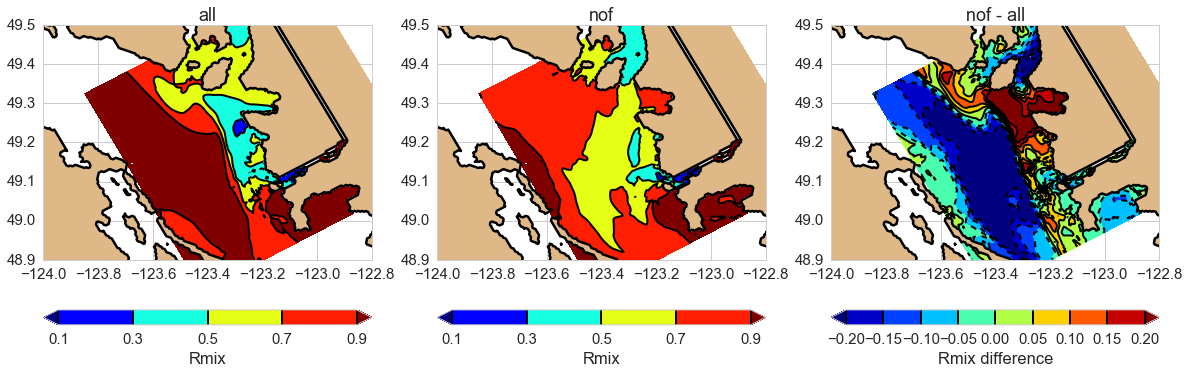

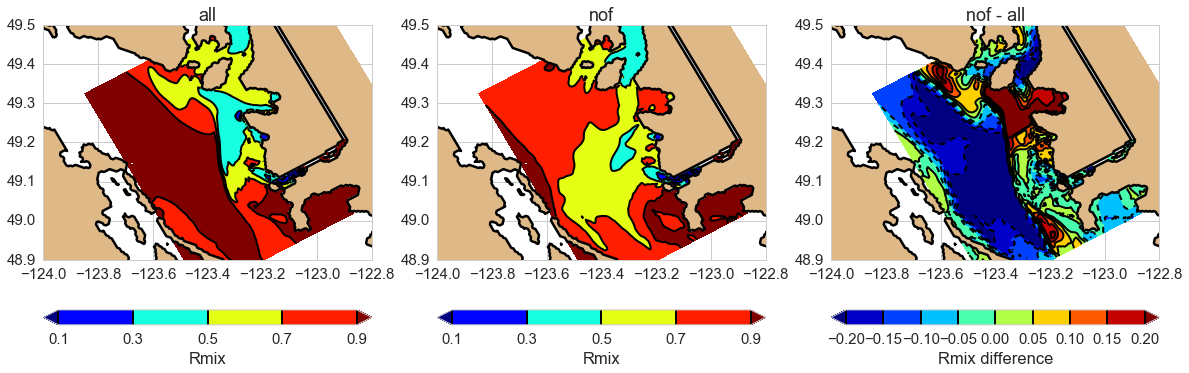

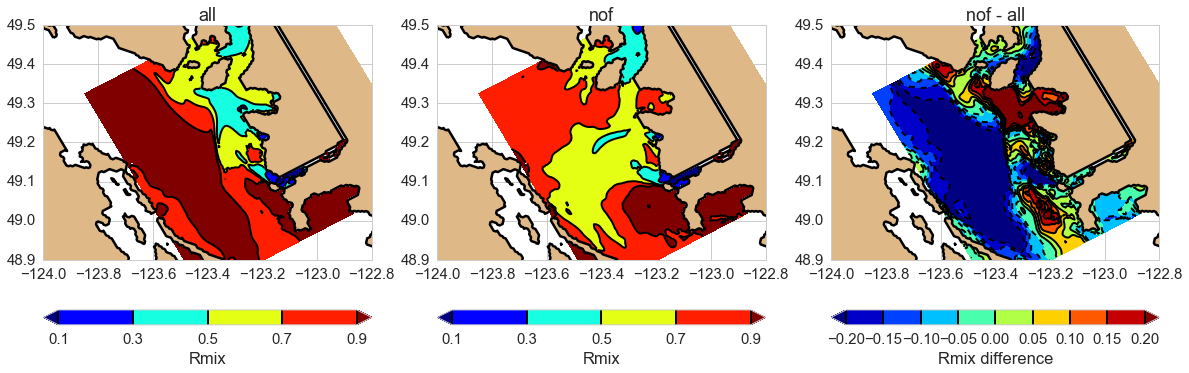

In [30]:
## peak ebb, slack and flood
rmix_each(octnof_T,octall_T,45+14,45+14,10)
rmix_each(octnof_T,octall_T,45+17,45+17,10)
rmix_each(octnof_T,octall_T,45+20,45+20,10)

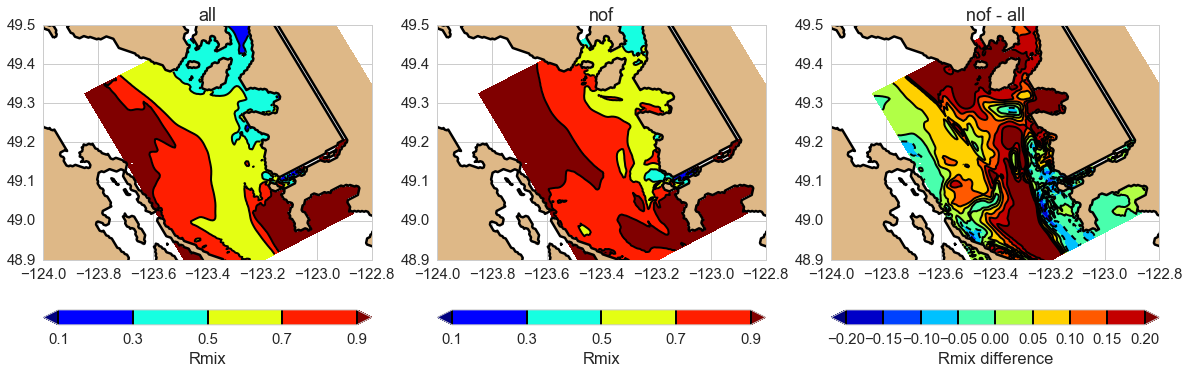

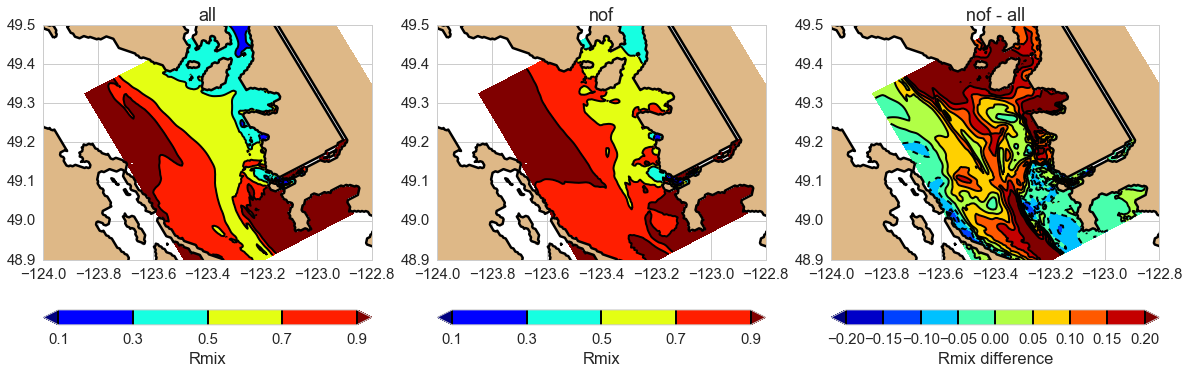

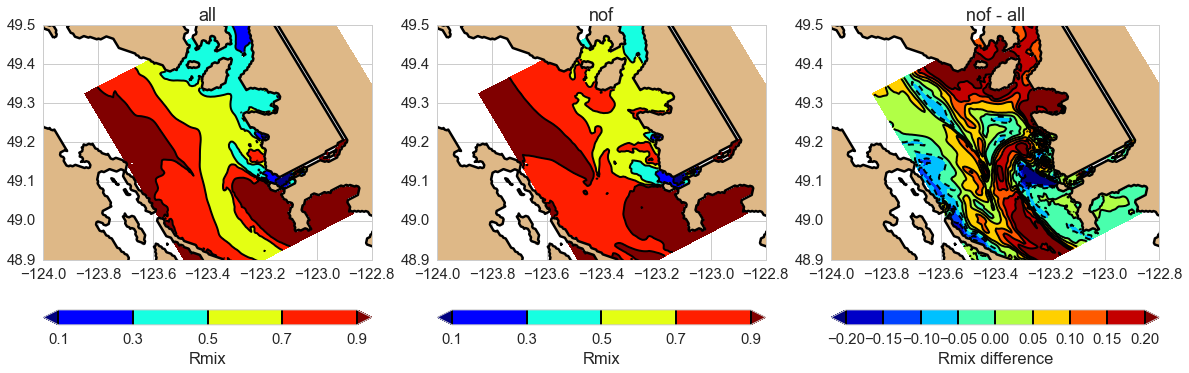

In [14]:
## peak ebb, slack and flood
rmix_each(octnof_T,octall_T,196,196,10)
rmix_each(octnof_T,octall_T,199,199,10)
rmix_each(octnof_T,octall_T,202,202,10)

* Jan

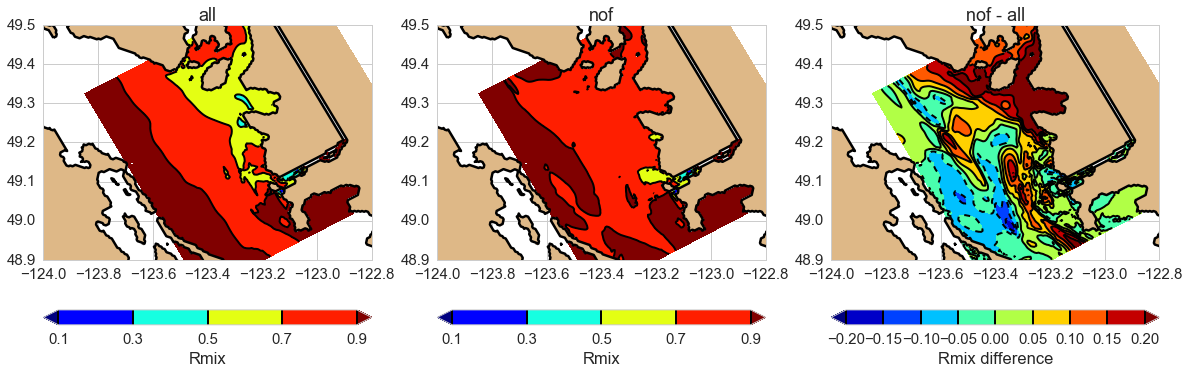

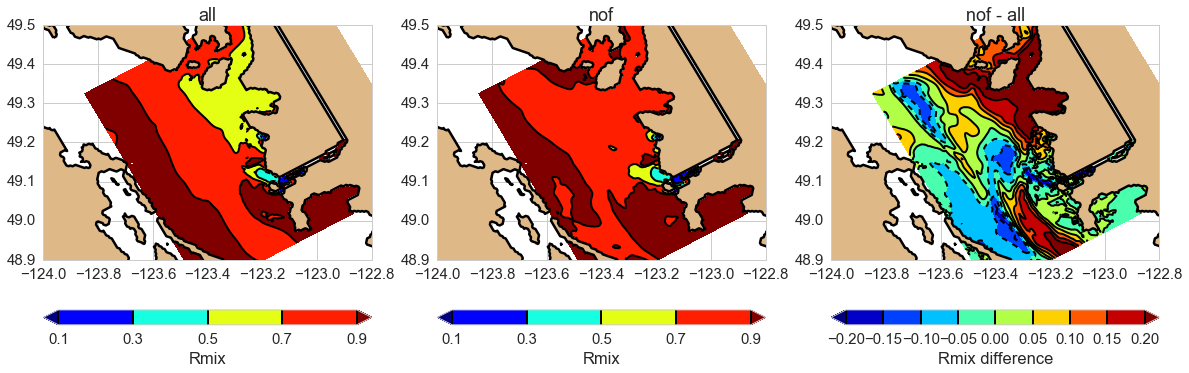

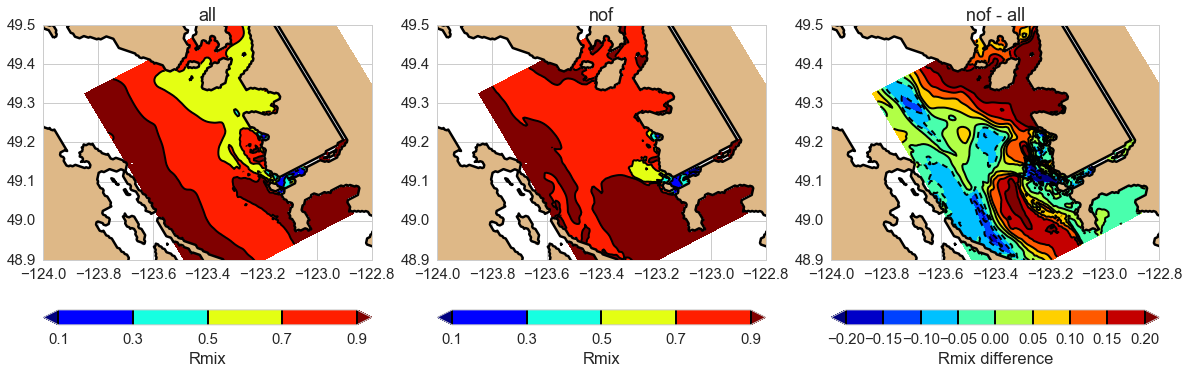

In [15]:
rmix_each(jannof_T,janall_T,195,195,10)
rmix_each(jannof_T,janall_T,199,199,10)
rmix_each(jannof_T,janall_T,202,202,10)

* May

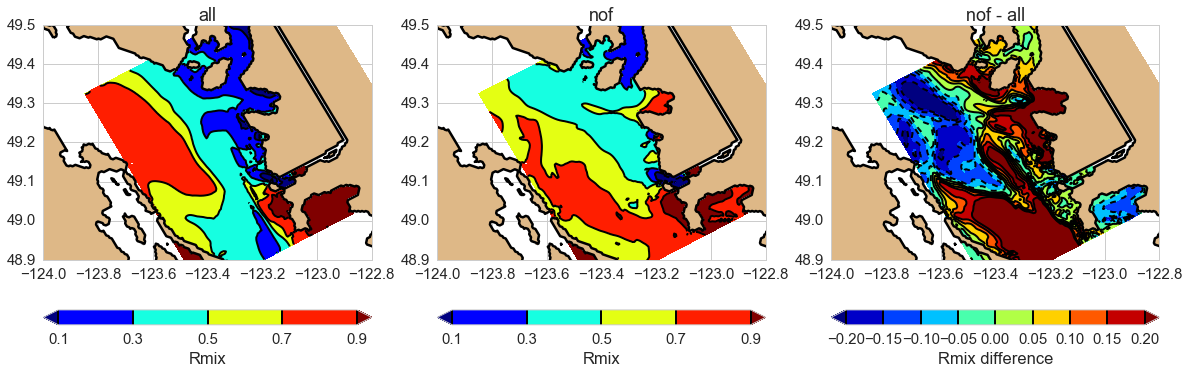

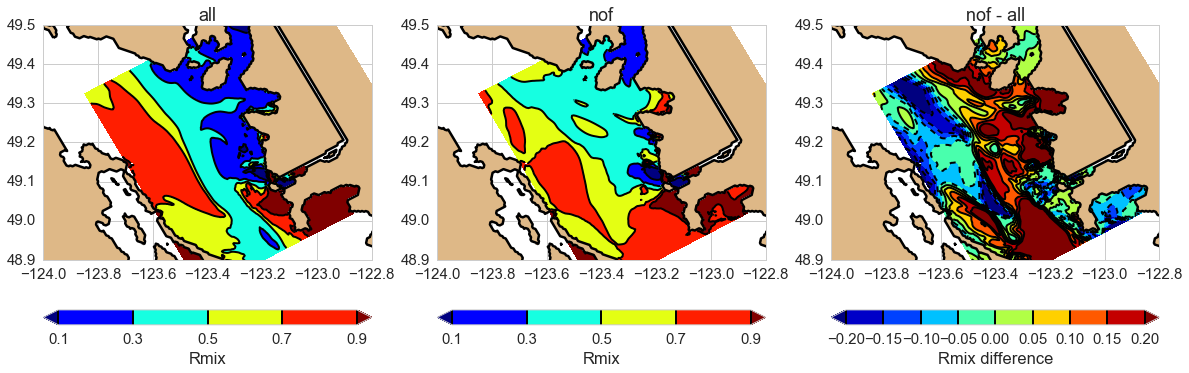

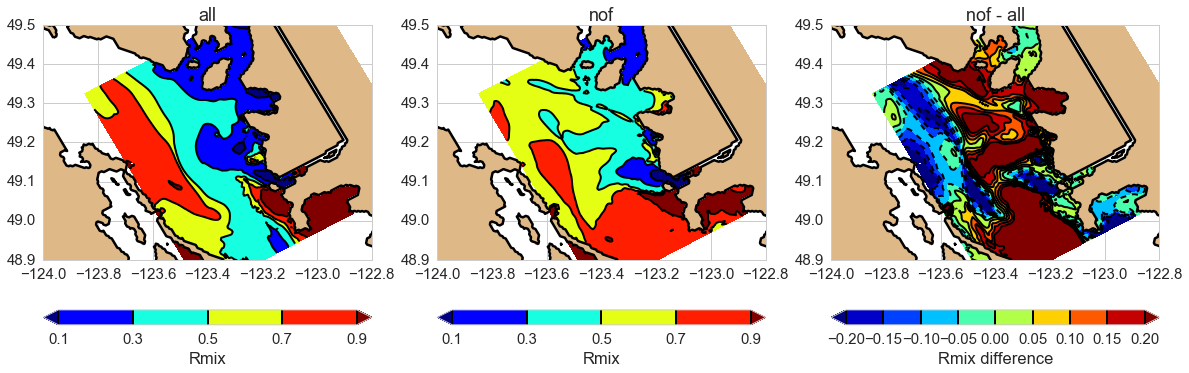

In [16]:
rmix_each(maynof_T,mayall_T,734,734,10)
rmix_each(maynof_T,mayall_T,738,738,10)
rmix_each(maynof_T,mayall_T,741,741,10)